In [1]:
#import libraries
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import collections
from scipy.optimize import curve_fit

Echange de pétrole entre tous les pays du monde qu'elle a retravaillé pour qu'elle soit plus exploitable (enlever les valeurs manquantes etc.)
Les liens sont orientés mais dans cet exercice, je ne veux que les liens rediriger. Je passe donc par pandas pour après le symétriser (en faisant la somme des directions). 

In [8]:
import pandas as pd
df=pd.read_csv('data/oilDB.csv',sep=',')
df.head()

,exp,imp,v
0,Afghanistan,Paraguay,2667.523
1,Albania,Bulgaria,1317.288
2,Albania,Czechia,10834.733
3,Albania,Egypt,9352.174
4,Albania,Greece,41345.449


In [9]:
# D'abord le graphique est dirigé.
dG=nx.from_pandas_edgelist(df,'exp','imp',['v'],create_using=nx.DiGraph())

In [10]:
# Je passe à un graphe non dirigé où le poids est la valeur des deux directions. 
G=nx.to_undirected(dG)
for (i,j) in G.edges():
    G[i][j]['weight']=0
    if (i,j) in dG.edges():
        G[i][j]['weight']=G[i][j]['weight']+dG[i][j]['v']
    if (j,i) in dG.edges():
        G[i][j]['weight']=G[i][j]['weight']+dG[j][i]['v']

In [11]:
list(G.edges(data=True))[:5]

[('Afghanistan',
  'Iran',
  {'v': 658642.0929999999, 'weight': 658642.0929999999}),
 ('Afghanistan', 'Azerbaijan', {'v': 72687.057, 'weight': 72687.057}),
 ('Afghanistan',
  'Kazakhstan',
  {'v': 128145.51199999999, 'weight': 128145.51199999999}),
 ('Afghanistan',
  'Turkmenistan',
  {'v': 66452.41900000001, 'weight': 66452.41900000001}),
 ('Afghanistan', 'Russian Federation', {'v': 40907.138, 'weight': 40907.138})]

In [12]:
nx.density(G)

0.17997716991502136

# Weight's distribution

In [13]:
def logBinning(degreeList,nbin):
    kmin=min(degreeList)
    kmax=max(degreeList)
    logBins = np.logspace(np.log10(kmin), np.log10(kmax),num=nbin)
    logBinDensity, binedges = np.histogram(degreeList, bins=logBins,density=True)
    logBins = np.delete(logBins, -1)
    return logBinDensity, logBins

In [14]:
weights=[G[u][v]['weight'] for (u,v) in G.edges()]

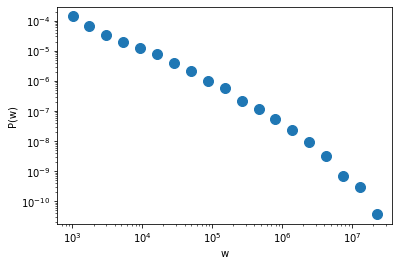

In [15]:
y,x=logBinning(np.array(weights),20)
plt.loglog(x,y,'o',markersize=10)
plt.xlabel('w')
plt.ylabel('P(w)')
plt.show()

# Strength distribution

In [19]:
s=list(dict(G.degree(weight='weight')).values())

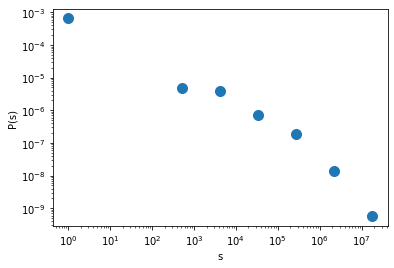

In [20]:
y,x=logBinning(np.array(s),10)
plt.loglog(x,y,'o',markersize=10)
plt.xlabel('s')
plt.ylabel('P(s)')
plt.show()

# Strength degree correlation

Relation entre la force et le degré. 
La force grandit avec le degré ici comme attendu. 

In [21]:
k=list(dict(G.degree()).values())

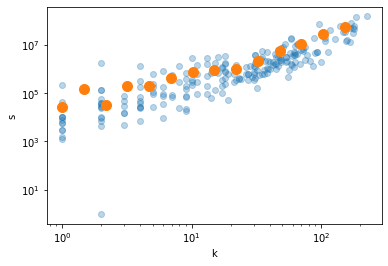

In [22]:
plt.loglog(k,s,'o',alpha=0.3)

logBins=np.logspace(np.log2(np.min(k)),np.log2(np.max(k)),base=2,num=15)
ybin,xbin,binnumber=scipy.stats.binned_statistic(k,s,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'o',markersize=10)

plt.xlabel('k')
plt.ylabel('s')
plt.show()

Je cherche à faire un fit. Si c'est linéaire, il y a peu de degrés entre k et s sinon il y a une relations. Je fais donc comme avant ma loi de puissance logarithmique. 

Les pays qui ont du pétrole vont vendre plus que les autres c'est logique. La pondération est dans ce cas associée à la structure topologiqu. 

In [23]:
def powerLaw(x, a, b):
    return b*x**(a)

1.3063774614774446


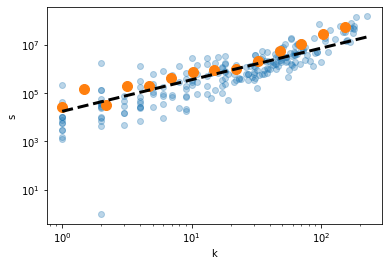

In [24]:
plt.loglog(k,s,'o',alpha=0.3)

#visualisation des données
logBins=np.logspace(np.log2(np.min(k)),np.log2(np.max(k)),base=2,num=15)
ybin,xbin,binnumber=scipy.stats.binned_statistic(k,s,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'o',markersize=10)

#on fait le fit jusqu'à k=50 pour être sûr que ça marche bien 
fitx=[i for (i,j) in zip(k,s) if  i<50] #k jusqu'à 50
fity=[j for (i,j) in zip(k,s) if i<50]
popt, pcov = curve_fit(powerLaw, fitx, fity)  
#popt, pcov = curve_fit(powerLaw, k, s)  
print (popt[0])
plt.loglog(sorted(k), powerLaw(sorted(k), *popt), '--',c='k',linewidth=3)

plt.xlabel('k')
plt.ylabel('s')
plt.show()

# ROBUSTNESS

Quelle est la robustesse du réseau ? 

### random failures

On enlève (attaque) aléatoirement des noeuds. Je choisis la fraction que j'enlève 1/20 = 5/100 des noeuds.
<mark>Alain dit qu'il faut faire 21 et pas 20</mark>

In [31]:
fList=np.linspace(0,1,20)
NtoRem=[int(i*G.number_of_nodes()) for i in fList]

In [32]:
print(NtoRem)

[0, 11, 22, 34, 45, 57, 68, 80, 91, 103, 114, 126, 137, 149, 160, 172, 183, 195, 206, 218]


In [ ]:
On v

In [29]:
import random
sf=[]
for nn in NtoRem[:-1]:
    # je copie mon graphe pour ne pas toucher au graphe initial
    thisG=G.copy()
    # je prends un échantillon aléatoire de ces noeuds. 
    ll=random.sample(G.nodes(),nn)
    # je les enlève du graphe
    thisG.remove_nodes_from(ll)
    #je calcule la taille de la plus grande composante (maximale)
    thisSf=len(max(sorted(nx.connected_components(thisG), key = len, reverse=True)))
    # j'ajoute la taille/nb noeud dans la liste sf. 
    sf.append(thisSf/float(G.number_of_nodes()))

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  """Entry point for launching an IPython kernel.


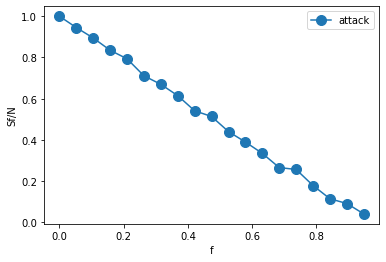

In [33]:
plt.plot(fList[:-1],sf,'o-',markerSize=10,label='random failure')
plt.xlabel('f')
plt.ylabel('Sf/N')
plt.legend()
plt.show()

### attacks

Attaque ciblée : j'enlève les noeuds aux degrés les plus importants. 

Rq : Ce travail peut être fait avec un réseau dirigé. Ce serait mieux de le faire d'ailleurs sur un réseau dirigé. 

In [34]:
hh=collections.Counter(dict(G.degree())).most_common()
#je classe les noeuds selon leur degré.
orderedNodes=[u for (u,v) in hh]

In [35]:
#10 premiers noeuds
print(orderedNodes[:10])

['USA', 'China', 'Netherlands', 'France', 'Germany', 'Russian Federation', 'Belgium', 'Italy', 'Turkey', 'United Arab Emirates']


In [36]:
fList1=np.linspace(0,1,20)
NtoRem=[int(i*G.number_of_nodes()) for i in fList1]

In [37]:
sfAtt=[]
for nn in NtoRem[:-1]:
    thisG=G.copy()
    # je prends les nn premiers dans le classement
    ll=orderedNodes[:nn]
    # je les enlève
    thisG.remove_nodes_from(ll)
    # je calcule la composante connectée
    thisSf=len(max(sorted(nx.connected_components(thisG), key = len, reverse=True)))
    sfAtt.append(thisSf/float(G.number_of_nodes()))

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  """Entry point for launching an IPython kernel.
C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  


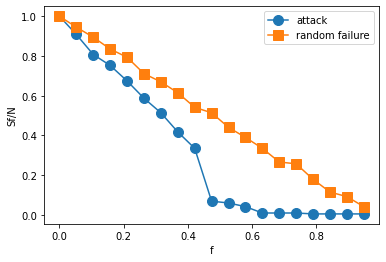

In [38]:
plt.plot(fList1[:-1],sfAtt,'o-',markerSize=10,label='attack')
plt.plot(fList[:-1],sf,'s-',markerSize=10,label='random failure')
plt.xlabel('f')
plt.ylabel('Sf/N')
plt.legend()
plt.show()

Les attaques ciblées sont plus efficaces que les attaques random car on se retrouve sur un réseau déconnecté. 